## Routerbench

In [1]:
from selection import auc_all
import numpy as np
from tqdm import tqdm
def bootstrap_normal(qualities_all, costs_all, baseline_qualities, baseline_costs, n_samples=500):
    np.random.seed(0)
    auc_values = []
    for _ in tqdm(range(n_samples)):
        indices = np.random.choice(range(len(qualities_all[0])), len(qualities_all[0]), replace=True)
        qualities = [np.mean(np.array(quality_index)[indices]) for quality_index in qualities_all]
        costs = [np.mean(np.array(cost_index)[indices]) for cost_index in costs_all]
        auc_values.append(auc_all(qualities, costs, baseline_qualities, baseline_costs)['auc'])
    return auc_values, np.mean(auc_values),np.array([1.96 * np.nanstd(auc_values), np.nanmean(auc_values) - np.percentile(auc_values, 97.5), np.nanmean(auc_values) - np.percentile(auc_values, 2.5)])

def bootstrap_diff(qualities_all, costs_all, qualities_all_2, costs_all_2, baseline_qualities, baseline_costs, n_samples=500):
    np.random.seed(0)
    auc_values = []
    for _ in tqdm(range(n_samples)):
        indices = np.random.choice(range(len(qualities_all[0])), len(qualities_all[0]), replace=True)
        qualities = [np.nanmean(np.array(quality_index)[indices]) for quality_index in qualities_all]
        costs = [np.nanmean(np.array(cost_index)[indices]) for cost_index in costs_all]
        qualities_2 = [np.nanmean(np.array(quality_index)[indices]) for quality_index in qualities_all_2]
        costs_2 = [np.nanmean(np.array(cost_index)[indices]) for cost_index in costs_all_2]
        auc1 = auc_all(qualities, costs, baseline_qualities, baseline_costs)['auc']
        auc2 = auc_all(qualities_2, costs_2, baseline_qualities, baseline_costs)['auc']
        auc_values.append(auc1 - auc2)
    return auc_values, np.nanmean(auc_values), np.array([1.96 * np.nanstd(auc_values), np.nanmean(auc_values) - np.percentile(auc_values, 97.5), np.nanmean(auc_values) - np.percentile(auc_values, 2.5)])

/local/home/jdekoninck/miniconda3/envs/selection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.model_selection import train_test_split
from selection import remove_redundant_models
import pandas as pd
import json

def load_data(shot):
    data = pd.read_csv(f'../data/routerbench_{shot}shot.csv')
    model_names = data.columns[3:14]
    qualities = data[model_names]
    cost_names = [model_name + '|total_cost' for model_name in model_names]
    costs = data[cost_names]
    # change column names
    costs.columns = model_names
    train_qualities, test_qualities, train_costs, test_costs = train_test_split(
                                qualities, costs, test_size=0.95, random_state=42                           
    )
    test_qualities_averaged = test_qualities.mean(axis=0)
    test_costs_averaged = test_costs.mean(axis=0)
    return test_qualities_averaged, test_costs_averaged, model_names, test_qualities, test_costs

def extract_results(files, base_path):
    all_results = {
        'linear': [],
        'routing': [],
        'cascading': [],
        'cascading_ours': [],
        'cascade_routing': []
    }
    for strategy in files:
        with open(base_path + strategy, 'r') as file:
            results = json.load(file)
            all_results['linear'].append(results['aucs_baseline']['auc'] * 100)
            all_results['routing'].append(results['aucs_router']['auc'] * 100)
            all_results['cascading'].append(results['aucs_cascade']['auc'] * 100)
            if 'aucs_cascade_ours' in results:
                all_results['cascading_ours'].append(results['aucs_cascade_ours']['auc'] * 100)
            else:
                all_results['cascading_ours'].append(0)
            all_results['cascade_routing'].append(results['aucs']['auc'] * 100)

    df = pd.DataFrame(all_results).T
    return df

def extract_results_bootstrap(files, base_path, test_qualities_averaged, test_costs_averaged, model_names, test_qualities, test_costs):
    all_results = {
        'linear': [],
        'routing': [],
        'cascading': [],
        'cascading_ours': [],
        'cascade_routing': []
    }

    for strategy in files:
        if "_" in strategy:
            split = [int(i) for i in strategy.split("_")[0].split(',')]
        else:
            split = [int(i) for i in strategy.split(".")[0].split(',')]
        baseline_costs_here = np.array(test_costs_averaged.iloc[split])
        baseline_qualities_here = np.array(test_qualities_averaged.iloc[split])
        with open(base_path + strategy, 'r') as file:
            results = json.load(file)
            _, _, indices = remove_redundant_models(baseline_qualities_here, baseline_costs_here)
            kept_names = [model_names[split[i]] for i in indices]
            linear_qualities = np.array(test_qualities[kept_names]).T
            linear_costs = np.array(test_costs[kept_names]).T
            mapping = {
                "linear": (linear_qualities, linear_costs),
                "routing": (results['router_test']['quality_all'], results['router_test']['cost_all']),
                "cascading": (results['cascade_test']['quality_all'], results['cascade_test']['cost_all']),
                "cascading_ours": (results['cascade_test_ours']['quality_all'], results['cascade_test_ours']['cost_all']),
                "cascade_routing": (results['test']['quality_all'], results['test']['cost_all'])
            }
            for key in mapping:
                if "cascade_routing" != key:
                    bootstrap = bootstrap_diff(mapping[key][0], mapping[key][1],
                                                results['test']['quality_all'], results['test']['cost_all'],
                                                baseline_qualities_here, baseline_costs_here)
                else:
                    bootstrap = bootstrap_normal(mapping[key][0], mapping[key][1],
                                        baseline_qualities_here, baseline_costs_here)
                all_results[key].append(f"${round(bootstrap[1] * 100, 2):2f}^{{+{round(bootstrap[2][2] * 100, 2):2f}}}_{{{round(bootstrap[2][1] * 100, 2):2f}}}$")

    df = pd.DataFrame(all_results).T
    return df

def routerbench_main(shot="0"):
    test_qualities_averaged, test_costs_averaged, model_names, test_qualities, test_costs = load_data(shot)
    files = [
            f'9,4,5_low_{shot}shot.json',
            f'9,4,5_medium_{shot}shot.json',
            f'9,4,5_high_{shot}shot.json',
            f'0,9,4,3,5_low_{shot}shot.json',
            f'0,9,4,3,5_medium_{shot}shot.json',
            f'0,9,4,3,5_high_{shot}shot.json',
            f'0,1,2,3,4,5,6,7,8,9,10_low_{shot}shot.json',
            f'0,1,2,3,4,5,6,7,8,9,10_medium_{shot}shot.json',
            f'0,1,2,3,4,5,6,7,8,9,10_high_{shot}shot.json'
    ]

    base_path = '../data/results/routerbench/'

    df = extract_results(files, base_path)
    # add avg column
    # to latex
    print(f"Table 1 from our paper, {shot}-shot results")
    print(df.to_latex(index=False))


    df = extract_results_bootstrap(files, base_path, test_qualities_averaged, test_costs_averaged, model_names, test_qualities, test_costs)
    # add avg column
    # to latex
    print("Table 4 from our paper")
    print(df.to_latex(index=False))


In [3]:
routerbench_main("0")

Table 1 from our paper, 0-shot results
\begin{tabular}{rrrrrrrrr}
\toprule
0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
69.619211 & 69.619211 & 69.619211 & 69.223137 & 69.223137 & 69.223137 & 70.506406 & 70.506406 & 70.506406 \\
79.726787 & 74.965568 & 71.812637 & 81.235991 & 74.432665 & 71.328369 & 83.245409 & 74.632066 & 72.670410 \\
80.863873 & 74.641304 & 72.475432 & 82.332691 & 73.029091 & 69.526597 & 84.480300 & 73.643526 & 69.788751 \\
81.087637 & 76.163850 & 72.668429 & 83.057026 & 75.169221 & 70.179556 & 84.468958 & 75.095880 & 70.255078 \\
82.364416 & 76.553922 & 73.216015 & 84.329598 & 76.313683 & 72.745103 & 87.243456 & 77.568917 & 74.404521 \\
\bottomrule
\end{tabular}



100%|██████████| 500/500 [00:46<00:00, 10.81it/s]


Table 4 from our paper
\begin{tabular}{lllllllll}
\toprule
0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
$-12.740000^{+0.210000}_{-0.230000}$ & $-6.930000^{+0.180000}_{-0.200000}$ & $-3.590000^{+0.190000}_{-0.190000}$ & $-15.090000^{+0.260000}_{-0.270000}$ & $-7.080000^{+0.210000}_{-0.210000}$ & $-3.520000^{+0.210000}_{-0.210000}$ & $-16.730000^{+0.270000}_{-0.280000}$ & $-7.060000^{+0.230000}_{-0.220000}$ & $-3.900000^{+0.230000}_{-0.230000}$ \\
$-2.640000^{+0.150000}_{-0.160000}$ & $-1.590000^{+0.130000}_{-0.150000}$ & $-1.400000^{+0.150000}_{-0.170000}$ & $-3.100000^{+0.170000}_{-0.150000}$ & $-1.880000^{+0.170000}_{-0.160000}$ & $-1.410000^{+0.170000}_{-0.170000}$ & $-4.000000^{+0.170000}_{-0.210000}$ & $-2.940000^{+0.200000}_{-0.210000}$ & $-1.730000^{+0.190000}_{-0.190000}$ \\
$-1.500000^{+0.120000}_{-0.120000}$ & $-1.910000^{+0.180000}_{-0.190000}$ & $-0.740000^{+0.190000}_{-0.180000}$ & $-2.000000^{+0.170000}_{-0.150000}$ & $-3.290000^{+0.260000}_{-0.270000}$ & $-3.220000^{+0.2

In [4]:
models = "0,9,4,3,5"
strategy = "low"
diff_sigma = 0.2
min_sigma, max_sigma = 0, 3.0
base_path = '../data/results/routerbench/'

results_diff_routing = []
results_diff_cascading = []
results_diff_cascading_ours = []
results_linear = []
results_cascade_routing = []
for sigma_before in tqdm(np.arange(min_sigma, max_sigma + diff_sigma / 2, diff_sigma)):
    for sigma_after in tqdm(np.arange(min_sigma, sigma_before + diff_sigma / 2, diff_sigma)):
        filename = f"0,9,4,3,5_low_0shot_{round(sigma_before, 1)},{round(sigma_after, 1)},0.0002,5e-05_False.json"
        results = json.load(open(base_path + filename, 'r'))
        results_diff_routing.append((sigma_before, sigma_after, results['aucs_router']['auc']))
        results_diff_cascading_ours.append((sigma_before, sigma_after, results['aucs_cascade_ours']['auc']))
        results_diff_cascading.append((sigma_before, sigma_after, results['aucs_cascade']['auc']))
        results_linear.append((sigma_before, sigma_after, results['aucs_baseline']['auc']))
        results_cascade_routing.append((sigma_before, sigma_after, results['aucs']['auc']))

100%|██████████| 16/16 [03:34<00:00, 13.38s/it]


In [5]:
results = {
    'routing': results_diff_routing,
    'cascading': results_diff_cascading,
    'cascading_ours': results_diff_cascading_ours,
    'linear': results_linear,
    'cascade_routing': results_cascade_routing
}

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def generate_plot(plot="routing"):
    diff_sigma = 0.2
    min_sigma, max_sigma = 0, 3.0
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

    xyz_data = []
    for result, other in zip(results["cascade_routing"], results[plot]):
        xyz_data.append([result[0], 
                        result[1], 
                        (result[2] - other[2]) * 100])

    data = np.array(xyz_data)
    xs = data[:, 0]
    ys = data[:, 1]
    zs = data[:, 2]
    Nx, Ny = 1000, 1000

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    grid_x = np.linspace(x_min, x_max, Nx)
    grid_y = np.linspace(y_min, y_max, Ny)

    X, Y = np.meshgrid(grid_x, grid_y)
    Z = griddata(points=(xs, ys), 
                values=zs, 
                xi=(X, Y), 
                method='cubic')

    imshow = ax.imshow(Z, origin='lower', cmap='coolwarm', interpolation='quadric', 
                    extent=[0, x_max + 0.01, 0, y_max + 0.01])


    range_xticks = np.arange(0, max_sigma + diff_sigma, diff_sigma * 3)
    range_xticks = [round(x, 1) for x in range_xticks]
    ax.set_xticks(range_xticks)
    # set font size
    ax.tick_params(labelsize=18)
    range_yticks = np.arange(0, max_sigma + diff_sigma, diff_sigma * 3)
    range_yticks = [round(x, 1) for x in range_yticks]
    ax.set_yticks(range_yticks)

    # remove grid
    sns.despine(left=True, bottom=True, right=True, top=True)
    ax.set_xlabel(r"$\sigma_\mathrm{ante}$", fontsize=24)
    ax.set_ylabel(r"$\sigma_\mathrm{post}$", fontsize=24)


    # set light gray background
    ax.set_facecolor((0.95, 0.95, 0.95))

    # add a colorbar, without spine
    cbar = plt.colorbar(imshow, ax=ax,fraction=0.046, pad=0.04)
    cbar.outline.set_visible(False)
    # set font size of colorbar
    cbar.ax.tick_params(labelsize=18)
    if plot == "routing":
        cbar.ax.set_yticks([0,3,6,9,12])
    else:
        cbar.ax.set_yticks([2,4,6,8])
    # make all white space tight
    fig.tight_layout()
    plt.show()
# make the colorbar match the height of the plot

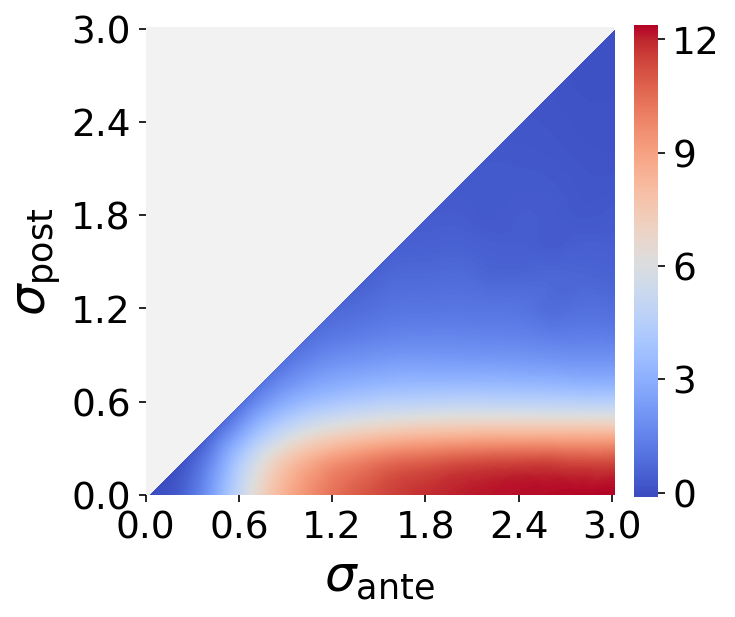

In [7]:
generate_plot("routing")

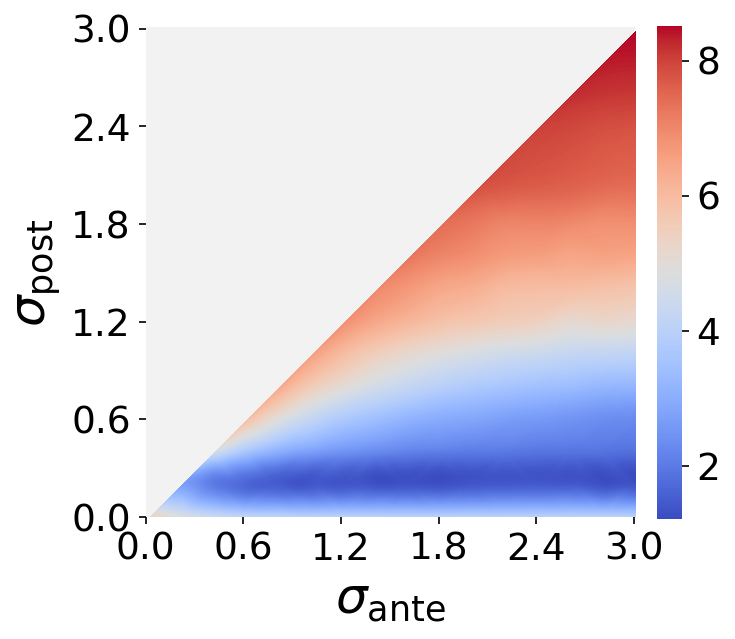

In [8]:
generate_plot("cascading")

In [9]:
routerbench_main("5")

Table 1 from our paper, 5-shot results
\begin{tabular}{rrrrrrrrr}
\toprule
0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
74.210281 & 74.210281 & 74.210281 & 73.823577 & 73.823577 & 73.823577 & 75.160194 & 75.160194 & 75.160194 \\
81.495843 & 77.223977 & 76.006404 & 82.425209 & 76.843640 & 75.542914 & 85.341982 & 77.767974 & 76.435299 \\
83.163363 & 78.578931 & 76.885932 & 84.271977 & 76.593376 & 73.918097 & 87.143259 & 78.603027 & 74.942672 \\
82.781413 & 78.771949 & 77.009444 & 84.259067 & 77.194329 & 74.298901 & 86.722471 & 78.671225 & 75.081530 \\
83.798999 & 78.858862 & 77.105493 & 85.503886 & 78.781568 & 76.750747 & 88.780025 & 80.900848 & 78.035322 \\
\bottomrule
\end{tabular}



100%|██████████| 500/500 [00:46<00:00, 10.72it/s]


Table 4 from our paper
\begin{tabular}{lllllllll}
\toprule
0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
$-9.560000^{+0.210000}_{-0.220000}$ & $-4.620000^{+0.180000}_{-0.170000}$ & $-2.870000^{+0.170000}_{-0.180000}$ & $-11.650000^{+0.230000}_{-0.240000}$ & $-4.930000^{+0.190000}_{-0.170000}$ & $-2.900000^{+0.150000}_{-0.160000}$ & $-13.600000^{+0.240000}_{-0.260000}$ & $-5.710000^{+0.220000}_{-0.200000}$ & $-2.850000^{+0.200000}_{-0.210000}$ \\
$-2.300000^{+0.140000}_{-0.130000}$ & $-1.640000^{+0.150000}_{-0.150000}$ & $-1.100000^{+0.130000}_{-0.140000}$ & $-3.080000^{+0.160000}_{-0.140000}$ & $-1.940000^{+0.160000}_{-0.140000}$ & $-1.210000^{+0.140000}_{-0.150000}$ & $-3.430000^{+0.150000}_{-0.170000}$ & $-3.130000^{+0.190000}_{-0.200000}$ & $-1.600000^{+0.170000}_{-0.160000}$ \\
$-0.640000^{+0.110000}_{-0.100000}$ & $-0.280000^{+0.130000}_{-0.140000}$ & $-0.220000^{+0.160000}_{-0.160000}$ & $-1.230000^{+0.120000}_{-0.120000}$ & $-2.190000^{+0.210000}_{-0.210000}$ & $-2.830000^{+0.24

## Other Benchmarks

In [29]:
import json
files = [
    # 893 is the moment where both cascading and cascading routing start to be constant (reach max quality at this cost)
    ('0,1,2,3,4,5,6,7,8,9.json', 893.2915208333334),
    ('0,1,2,3,8.json', 498.4275722135417)
]

base_path = '../data/results/swebench/'

all_results = {
    'linear': [],
    'routing': [],
    'cascading': [],
    'cascading_ours': [],
    'cascade_routing': [],
}

for file_name, max_cost in files:
    with open(base_path + file_name, 'r') as file:
        results = json.load(file)
        qualities, costs, _ = remove_redundant_models(results['qualities_baseline'], results['costs_baseline'])
        cost_arg = costs + [max_cost]
        qualities_arg = qualities + [max(qualities)]
        linear = auc_all(qualities, costs, qualities_arg, cost_arg)['auc'] * 100
        router = auc_all(results['router_test']['quality'], results['router_test']["cost"], qualities_arg, cost_arg)['auc'] * 100
        cascade = auc_all(results['cascade_test']['quality'], results['cascade_test']["cost"], qualities_arg, cost_arg)['auc'] * 100
        cascade_ours = auc_all(results['cascade_test_ours']['quality'], results['cascade_test_ours']["cost"], 
                               qualities_arg, cost_arg)['auc'] * 100
        cascade_routing = auc_all(results['test']['quality'], results['test']["cost"], qualities_arg, cost_arg)['auc'] * 100
        all_results['linear'].append(linear)
        all_results['routing'].append(router)
        all_results['cascading'].append(cascade)
        all_results['cascading_ours'].append(cascade_ours)
        all_results['cascade_routing'].append(cascade_routing)

df = pd.DataFrame(all_results).T
# to latex
print('Table 2 from our paper, Swebench')
print(df.to_latex(index=False))

Table 2 from our paper, Swebench
\begin{tabular}{rr}
\toprule
0 & 1 \\
\midrule
40.505392 & 38.637494 \\
40.491937 & 39.395796 \\
38.519802 & 45.890315 \\
53.206177 & 50.944446 \\
54.121852 & 51.090586 \\
\bottomrule
\end{tabular}



In [30]:
import json
import numpy as np
import pandas as pd
from selection import remove_redundant_models
import os
dataset = 'swebench'
data_folder = '../data'

test_model_answers = pd.read_json(os.path.join(data_folder, dataset, 'test', 'model_answers.json'))
test_costs = pd.read_json(os.path.join(data_folder, dataset, 'test', 'costs.json'))
test_qualities = pd.read_json(os.path.join(data_folder, dataset, 'test', 'qualities.json'))
test_queries = list(pd.read_json(os.path.join(data_folder, dataset, 'test', 'queries.json'))[0])

test_qualities_averaged = test_qualities.mean(axis=0)
test_costs_averaged = test_costs.mean(axis=0)

model_names = test_qualities.columns

np.random.seed(0)
train_indices = np.random.choice(len(test_queries), len(test_queries) // 2, replace=False)
test_indices = np.array([i for i in range(len(test_queries)) if i not in train_indices])
train_queries = [test_queries[i] for i in train_indices]
train_model_answers = test_model_answers.iloc[train_indices]
train_costs = test_costs.iloc[train_indices]
train_qualities = test_qualities.iloc[train_indices]
test_queries = [test_queries[i] for i in test_indices]
test_model_answers = test_model_answers.iloc[test_indices]
test_costs = test_costs.iloc[test_indices]
test_qualities = test_qualities.iloc[test_indices]

In [32]:
all_results = {
    'routing': [],
    'cascading': [],
    'cascading_ours': [],
    'cascade_routing': []
}

for file_name, max_cost in files:
    split = [int(i) for i in file_name[:-5].split(',')]
    
    with open(base_path + file_name, 'r') as file:
        results = json.load(file)
        baseline_costs_here = results['costs_baseline'] + [max_cost]
        baseline_qualities_here = results['qualities_baseline'] + [max(results['qualities_baseline'])]
        mapping = {
            "routing": (results['router_test']['quality_all'], results['router_test']['cost_all']),
            "cascading": (results['cascade_test']['quality_all'], results['cascade_test']['cost_all']),
            "cascading_ours": (results['cascade_test_ours']['quality_all'], results['cascade_test_ours']['cost_all']),
            "cascade_routing": (results['test']['quality_all'], results['test']['cost_all'])
        }
        for key in mapping:
            if "cascade_routing" != key:
                bootstrap = bootstrap_diff(mapping[key][0], mapping[key][1],
                                            results['test']['quality_all'], results['test']['cost_all'],
                                            baseline_qualities_here, baseline_costs_here)
            else:
                bootstrap = bootstrap_normal(mapping[key][0], mapping[key][1],
                                            baseline_qualities_here, baseline_costs_here)
            all_results[key].append(f"${round(bootstrap[1] * 100, 2):2f}^{{+{round(bootstrap[2][2] * 100, 2):2f}}}_{{{round(bootstrap[2][1] * 100, 2):2f}}}$")


df = pd.DataFrame(all_results).T
# add avg column
# to latex
print("Table 6 from our paper, swebench")
print(df.to_latex(index=False))

100%|██████████| 500/500 [00:01<00:00, 287.43it/s]

Table 6 from our paper, swebench
\begin{tabular}{ll}
\toprule
0 & 1 \\
\midrule
$-13.650000^{+4.500000}_{-4.320000}$ & $-11.710000^{+4.390000}_{-4.140000}$ \\
$-15.360000^{+3.900000}_{-3.220000}$ & $-5.170000^{+1.690000}_{-1.630000}$ \\
$-0.830000^{+1.900000}_{-1.500000}$ & $-0.110000^{+1.050000}_{-1.040000}$ \\
$54.210000^{+7.490000}_{-7.170000}$ & $51.200000^{+7.440000}_{-7.220000}$ \\
\bottomrule
\end{tabular}



In [13]:
import json
files = [
    '0,1,2,3.json',
]

base_path = '../data/results/livecodebench_minerva/'

df = extract_results(files, base_path)
# to latex
print('Table 2 from our paper, Math+code')
print(df.to_latex(index=False))

Table 2 from our paper, Math+code
\begin{tabular}{r}
\toprule
0 \\
\midrule
39.626901 \\
47.463307 \\
37.677355 \\
46.763934 \\
48.549854 \\
\bottomrule
\end{tabular}



In [14]:
dataset = 'livecodebench_minerva'
data_folder = '../data/code_math'

test_model_answers = pd.read_json(os.path.join(data_folder, dataset, 'test', 'model_answers.json'))
test_costs = pd.read_json(os.path.join(data_folder, dataset, 'test', 'costs.json'))
test_qualities = pd.read_json(os.path.join(data_folder, dataset, 'test', 'qualities.json'))
test_queries = list(pd.read_json(os.path.join(data_folder, dataset, 'test', 'queries.json'))[0])

test_qualities_averaged = test_qualities.mean(axis=0)
test_costs_averaged = test_costs.mean(axis=0)
model_names = test_qualities.columns

np.random.seed(0)
train_indices = np.random.choice(len(test_queries), len(test_queries) // 2, replace=False)
test_indices = np.array([i for i in range(len(test_queries)) if i not in train_indices])
train_queries = [test_queries[i] for i in train_indices]
train_model_answers = test_model_answers.iloc[train_indices]
train_costs = test_costs.iloc[train_indices]
train_qualities = test_qualities.iloc[train_indices]
test_queries = [test_queries[i] for i in test_indices]
test_model_answers = test_model_answers.iloc[test_indices]
test_costs = test_costs.iloc[test_indices]
test_qualities = test_qualities.iloc[test_indices]

In [15]:
df = extract_results_bootstrap(files, base_path, test_qualities_averaged, test_costs_averaged, model_names, test_qualities, test_costs)
# add avg column
# to latex
print("Table 6 from our paper, minerva math + livecodebench part")
print(df.to_latex(index=False))

100%|██████████| 500/500 [00:03<00:00, 155.92it/s]

Table 6 from our paper, minerva math + livecodebench part
\begin{tabular}{l}
\toprule
0 \\
\midrule
$-8.870000^{+1.450000}_{-1.340000}$ \\
$-1.110000^{+0.810000}_{-0.800000}$ \\
$-10.770000^{+1.710000}_{-1.720000}$ \\
$-1.820000^{+0.580000}_{-0.550000}$ \\
$48.510000^{+2.950000}_{-2.990000}$ \\
\bottomrule
\end{tabular}



In [16]:
import json
files = [
    '0,1,2.json',
    '3,4,5.json',
    '6,7,8.json',
]

base_path = '../data/results/classification/mmlu_arc_mixeval/'

df = extract_results(files, base_path)
# to latex
print('Table 2 from our paper, first half on classification')
print(df.to_latex(index=False))

Table 2 from our paper, first half on classification
\begin{tabular}{rrr}
\toprule
0 & 1 & 2 \\
\midrule
74.282600 & 61.683007 & 63.389435 \\
74.921240 & 64.439964 & 64.890300 \\
74.807582 & 54.319901 & 61.202081 \\
75.458600 & 62.786118 & 63.311541 \\
75.516728 & 64.835861 & 64.970347 \\
\bottomrule
\end{tabular}



In [17]:
import json
import numpy as np
import pandas as pd
from selection import remove_redundant_models
import os

base_path = '../data/results/classification/mmlu_arc_mixeval/'

dataset = 'mmlu_arc_mixeval'
data_folder = '../data/classification'

test_model_answers = pd.read_json(os.path.join(data_folder, dataset, 'test', 'model_answers.json'))
test_costs = pd.read_json(os.path.join(data_folder, dataset, 'test', 'costs.json'))
test_qualities = pd.read_json(os.path.join(data_folder, dataset, 'test', 'qualities.json'))
test_queries = list(pd.read_json(os.path.join(data_folder, dataset, 'test', 'queries.json'))[0])

test_qualities_averaged = test_qualities.mean(axis=0)
test_costs_averaged = test_costs.mean(axis=0)

model_names = test_qualities.columns

In [18]:
test_queries_df = pd.DataFrame(json.load(open('../data/classification/mmlu_arc_mixeval/test/queries.json'))['0']).T

In [19]:
def subselect_qualities_costs(qualities_all, costs_all, queries, dataset):
    qualities = []
    costs = []
    for qualities_all_here in qualities_all:
        quality = np.array(qualities_all_here)[np.array(queries[dataset + 1]).astype(bool)]
        qualities.append(quality)
    for costs_all_here in costs_all:
        cost = np.array(costs_all_here)[np.array(queries[dataset + 1]).astype(bool)]
        costs.append(cost)
    return qualities, costs

def get_auc_dataset(qualities_all, costs_all, queries, dataset, qualities_baseline, costs_baseline):
    qualities, costs = subselect_qualities_costs(qualities_all, costs_all, queries, dataset)
    qualities_mean = np.mean(np.array(qualities), axis=1)
    costs_mean = np.mean(np.array(costs), axis=1)
    return auc_all(qualities_mean, costs_mean, qualities_baseline, costs_baseline)['auc']

def get_results_individual(files, base_path, test_qualities, test_costs, test_queries_df, n_datasets=3):
    all_results = {
            'linear': [],
            'routing': [],
            'cascading': [],
            'cascading_ours': [],
            'cascade_routing': []
        }
    for file_name in files:
        for dataset in range(n_datasets):
        
            models = [int(i) for i in file_name[:-5].split(',')]
            qualities_models = np.array(test_qualities[model_names[models]]).T
            costs_models = np.array(test_costs[model_names[models]]).T
            qualities_baseline, costs_baseline = subselect_qualities_costs(qualities_models, costs_models, test_queries_df, dataset)
            qualities_baseline_averaged = np.mean(np.array(qualities_baseline), axis=1)
            costs_baseline_averaged = np.mean(np.array(costs_baseline), axis=1)
            with open(base_path + file_name, 'r') as file:
                results = json.load(file)
                mapping = {
                    "linear": (qualities_models, costs_models),
                    "routing": (results['router_test']['quality_all'], results['router_test']['cost_all']),
                    "cascading": (results['cascade_test']['quality_all'], results['cascade_test']['cost_all']),
                    "cascading_ours": (results['cascade_test_ours']['quality_all'], results['cascade_test_ours']['cost_all']),
                    "cascade_routing": (results['test']['quality_all'], results['test']['cost_all'])
                }
                for key in mapping:
                    auc = get_auc_dataset(mapping[key][0], mapping[key][1], test_queries_df, dataset, qualities_baseline_averaged, costs_baseline_averaged)
                    all_results[key].append(f"${round(auc * 100, 2):2f}$")

    df = pd.DataFrame(all_results).T
    # to latex
    print('Table 2 from our paper, second half on classification, per dataset', dataset)
    print(df.to_latex(index=False))

get_results_individual(files, base_path, test_qualities, test_costs, test_queries_df)

Table 2 from our paper, second half on classification, per dataset 2
\begin{tabular}{lllllllll}
\toprule
0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
$53.820000$ & $93.150000$ & $82.860000$ & $39.400000$ & $82.280000$ & $70.970000$ & $39.760000$ & $85.390000$ & $73.030000$ \\
$55.320000$ & $93.120000$ & $82.860000$ & $40.010000$ & $83.130000$ & $73.120000$ & $40.610000$ & $85.640000$ & $74.280000$ \\
$54.800000$ & $94.080000$ & $84.150000$ & $36.430000$ & $77.530000$ & $66.100000$ & $36.990000$ & $83.880000$ & $72.730000$ \\
$55.050000$ & $94.160000$ & $84.000000$ & $37.680000$ & $79.800000$ & $70.570000$ & $37.030000$ & $86.270000$ & $74.420000$ \\
$55.400000$ & $93.900000$ & $83.910000$ & $39.930000$ & $83.740000$ & $73.160000$ & $40.560000$ & $86.520000$ & $74.640000$ \\
\bottomrule
\end{tabular}



In [20]:
df = extract_results_bootstrap(files, base_path, test_qualities_averaged, test_costs_averaged, model_names, test_qualities, test_costs)
# add avg column
# to latex
print("Table 6 from our paper, classification part")
print(df.to_latex(index=False))

100%|██████████| 500/500 [00:04<00:00, 113.34it/s]

Table 6 from our paper, classification part
\begin{tabular}{lll}
\toprule
0 & 1 & 2 \\
\midrule
$-1.230000^{+0.280000}_{-0.270000}$ & $-3.150000^{+0.430000}_{-0.360000}$ & $-1.600000^{+0.520000}_{-0.530000}$ \\
$-0.600000^{+0.320000}_{-0.340000}$ & $-0.390000^{+0.500000}_{-0.470000}$ & $-0.080000^{+0.120000}_{-0.100000}$ \\
$-0.710000^{+0.300000}_{-0.280000}$ & $-10.510000^{+0.620000}_{-0.610000}$ & $-3.790000^{+0.730000}_{-0.770000}$ \\
$-0.060000^{+0.150000}_{-0.170000}$ & $-2.040000^{+0.330000}_{-0.310000}$ & $-1.670000^{+0.410000}_{-0.420000}$ \\
$75.560000^{+1.220000}_{-1.160000}$ & $64.890000^{+1.360000}_{-1.420000}$ & $65.020000^{+1.400000}_{-1.240000}$ \\
\bottomrule
\end{tabular}



In [21]:
files = [
    '0,1,2.json',
    '3,4,5.json',
    '6,7,8.json',
]

base_path = '../data/results/free_form/mmlu_gsm8k/'

df = extract_results(files, base_path)
# to latex
print('Table 2 from our paper, second half on open-form')
print(df.to_latex(index=False))

Table 2 from our paper, second half on open-form
\begin{tabular}{rrr}
\toprule
0 & 1 & 2 \\
\midrule
79.113000 & 54.097636 & 53.859567 \\
79.318910 & 58.395591 & 58.705107 \\
79.224978 & 56.184755 & 48.294154 \\
79.671507 & 57.655633 & 55.685703 \\
79.877363 & 59.656503 & 58.728561 \\
\bottomrule
\end{tabular}



In [22]:
import json
import numpy as np
import pandas as pd
from selection import remove_redundant_models
import os

base_path = '../data/results/free_form/mmlu_gsm8k/'

dataset = 'mmlu_gsm8k'
data_folder = '../data/free_form'

test_model_answers = pd.read_json(os.path.join(data_folder, dataset, 'test', 'model_answers.json'))
test_costs = pd.read_json(os.path.join(data_folder, dataset, 'test', 'costs.json'))
test_qualities = pd.read_json(os.path.join(data_folder, dataset, 'test', 'qualities.json'))
test_queries = pd.read_json(os.path.join(data_folder, dataset, 'test', 'queries.json'))

test_queries = list(test_queries.apply(lambda x: [x[0][0][1] + '\nQuestion: ' + x[1][1] + '\nAnswer:' + x[2][1] + '\nQuestion:' + x[3][1]] + x[0][1:], axis=1))

test_qualities_averaged = test_qualities.mean(axis=0)
test_costs_averaged = test_costs.mean(axis=0)

model_names = test_qualities.columns

test_queries_df = pd.DataFrame(json.load(open('../data/free_form/mmlu_gsm8k/test/queries.json'))['0']).T

In [23]:
get_results_individual(files, base_path, test_qualities, test_costs, test_queries_df, 2)

Table 2 from our paper, second half on classification, per dataset 1
\begin{tabular}{llllll}
\toprule
0 & 1 & 2 & 3 & 4 & 5 \\
\midrule
$65.640000$ & $94.430000$ & $36.520000$ & $73.860000$ & $41.400000$ & $67.840000$ \\
$65.750000$ & $94.150000$ & $38.080000$ & $75.010000$ & $43.030000$ & $68.000000$ \\
$66.070000$ & $95.170000$ & $35.760000$ & $68.440000$ & $38.880000$ & $60.820000$ \\
$66.250000$ & $94.940000$ & $38.160000$ & $71.100000$ & $40.760000$ & $64.530000$ \\
$66.600000$ & $94.690000$ & $40.430000$ & $75.250000$ & $42.930000$ & $68.300000$ \\
\bottomrule
\end{tabular}



In [24]:

df = extract_results_bootstrap(files, base_path, test_qualities_averaged, test_costs_averaged, model_names, test_qualities, test_costs)
# to latex
print("Table 6 from our paper, classification part")
print(df.to_latex(index=False))

100%|██████████| 500/500 [00:03<00:00, 138.62it/s]

Table 6 from our paper, classification part
\begin{tabular}{lll}
\toprule
0 & 1 & 2 \\
\midrule
$-0.770000^{+0.300000}_{-0.350000}$ & $-5.550000^{+0.500000}_{-0.470000}$ & $-4.850000^{+0.850000}_{-0.760000}$ \\
$-0.560000^{+0.380000}_{-0.420000}$ & $-1.260000^{+0.570000}_{-0.550000}$ & $-0.020000^{+0.050000}_{-0.050000}$ \\
$-0.650000^{+0.230000}_{-0.270000}$ & $-3.470000^{+0.370000}_{-0.400000}$ & $-10.450000^{+1.150000}_{-1.060000}$ \\
$-0.200000^{+0.190000}_{-0.190000}$ & $-2.000000^{+0.250000}_{-0.250000}$ & $-3.060000^{+0.650000}_{-0.630000}$ \\
$79.950000^{+1.280000}_{-1.330000}$ & $59.700000^{+1.620000}_{-1.610000}$ & $58.770000^{+1.420000}_{-1.500000}$ \\
\bottomrule
\end{tabular}



## Ablation

In [34]:
files = {
    'low': {
        'normal': '0,1,2,3,4,5,6,7,8,9,10_low_0shot_False_False_False.json',
        'greedy': '0,1,2,3,4,5,6,7,8,9,10_low_0shot_False_True_False.json',
        'no_deviation': '0,1,2,3,4,5,6,7,8,9,10_low_0shot_False_False_True.json',
        'no_speedup': '0,1,2,3,4,5,6,7,8,9,10_low_0shot_True_False_False.json',
    },
    'medium': {
        'normal': '0,1,2,3,4,5,6,7,8,9,10_medium_0shot_False_False_False.json',
        'greedy': '0,1,2,3,4,5,6,7,8,9,10_medium_0shot_False_True_False.json',
        'no_deviation': '0,1,2,3,4,5,6,7,8,9,10_medium_0shot_False_False_True.json',
        'no_speedup': '0,1,2,3,4,5,6,7,8,9,10_medium_0shot_True_False_False.json',
    },
    'high': {
        'normal': '0,1,2,3,4,5,6,7,8,9,10_high_0shot_False_False_False.json',
        'greedy': '0,1,2,3,4,5,6,7,8,9,10_high_0shot_False_True_False.json',
        'no_deviation': '0,1,2,3,4,5,6,7,8,9,10_high_0shot_False_False_True.json',
        'no_speedup': '0,1,2,3,4,5,6,7,8,9,10_high_0shot_True_False_False.json',
    },
}
base_path = '../data/results/routerbench_times/'

all_results = {
    'normal': [],
    'greedy': [],
    'no_deviation': [],
    'no_speedup': []
}

for n in files:
    for strategy in files[n]:
        with open(base_path + files[n][strategy], 'r') as file:
            results = json.load(file)
            all_results[strategy].append(results['aucs']['auc'] * 100)
            all_results[strategy].append(np.mean(results['test']['mean_times']) * 1000)

df = pd.DataFrame(all_results).T
# add avg column
# to latex
print('Table 7 from our paper')
print(df.to_latex(index=False))

Table 7 from our paper
\begin{tabular}{rrrrrr}
\toprule
0 & 1 & 2 & 3 & 4 & 5 \\
\midrule
87.288663 & 15.263219 & 77.606260 & 9.525337 & 74.408804 & 13.684285 \\
85.930465 & 1.387429 & 77.166754 & 1.173892 & 74.350349 & 0.885655 \\
85.977675 & 4.784659 & 77.111513 & 2.492010 & 74.347163 & 2.080314 \\
87.299149 & 78.883860 & 77.608258 & 87.722173 & 74.395604 & 88.757837 \\
\bottomrule
\end{tabular}

